# Regression project 3: Predicting waiter tips

**Team members: Ronald**<br>

### About dataset
Source: https://www.kaggle.com/datasets/jsphyg/tipping

**Context**

One waiter recorded information about each tip he received over a period of a few months working in one restaurant. In all he recorded 244 tips.

Can you predict the tip amount?

**Acknowledgements**

The data was reported in a collection of case studies for business statistics.

Bryant, P. G. and Smith, M (1995) Practical Data Analysis: Case Studies in Business Statistics. Homewood, IL: Richard D. Irwin Publishing

The dataset is also available through the Python package Seaborn. 

-------- **COLUMNS** --------

**total_bill**
bill in dollars

**tip**
tip in dollars

**sex**
sex of the bill payer

**smoker**
whether there were smokers in the party

**day**
day of the week

**time**
time of day

**size**
size of the party

In [1]:
# reference to the data
data_file = './data/tips.csv'

## Imports and settings

In [2]:
# imports
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# import my personal library
sys.path.insert(0, '../../ronaldlib/')
import ronaldlib.utils as rutils

# settings
pd.options.display.float_format = "{:.2f}".format

## Data loading

In [3]:
# load the data
df = rutils.load_data(data_file)

loading data from pickle file...
data loaded (took 0.0 seconds)


## Identify features and labels

In [4]:
# show some column info
rutils.show_column_info(df, show_centrality_and_dispersion=True)

       COLUMN     TYPE  VALID CNT  MISSING CNT  UNIQUE CNT
0        size    int64        244            0           6
1         tip  float64        244            0         123
2  total_bill  float64        244            0         229
3         sex   object        244            0           2
4      smoker   object        244            0           2
5        time   object        244            0           2
6         day   object        244            0           4

### Measures of centrality and dispersion ###
            count  mean  std  min   25%   50%   75%   max
total_bill 244.00 19.79 8.90 3.07 13.35 17.80 24.13 50.81
tip        244.00  3.00 1.38 1.00  2.00  2.90  3.56 10.00
size       244.00  2.57 0.95 1.00  2.00  2.00  3.00  6.00

Top 5 strings in column 'sex':
1. Male (count=157)
2. Female (count=87)

Top 5 strings in column 'smoker':
1. No (count=151)
2. Yes (count=93)

Top 5 strings in column 'day':
1. Sat (count=87)
2. Sun (count=76)
3. Thur (count=62)
4. Fri (count=19)


## Encoding data Categorical to numerical/ordinal (if needed)
We will
* recode binary variables from strings to 0, 1
* recode the non-binary categorical variable 'day' to 0/1 dummy variables

In [5]:
# recode binary variables
df['sex'] = df['sex'].map({'Female': 0, 'Male': 1})
df['smoker'] = df['smoker'].map({'No': 0, 'Yes': 1})
df['time'] = df['time'].map({'Lunch': 0, 'Dinner': 1})

# recode 'day', which is a non-binary categorical variable
df = pd.get_dummies(df, columns=['day'])

# drop one of the created variables to avoid redudance (this will be our reference value)
df = df.drop(columns='day_Thur')
df

,total_bill,tip,sex,smoker,time,size,day_Fri,day_Sat,day_Sun
0,16.99,1.01,0,0,1,2,False,False,True
1,10.34,1.66,1,0,1,3,False,False,True
2,21.01,3.50,1,0,1,3,False,False,True
3,23.68,3.31,1,0,1,2,False,False,True
4,24.59,3.61,0,0,1,4,False,False,True
...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,1,0,1,3,False,True,False
240,27.18,2.00,0,1,1,2,False,True,False
241,22.67,2.00,1,1,1,2,False,True,False
242,17.82,1.75,1,0,1,2,False,True,False


## Visualizing the columns

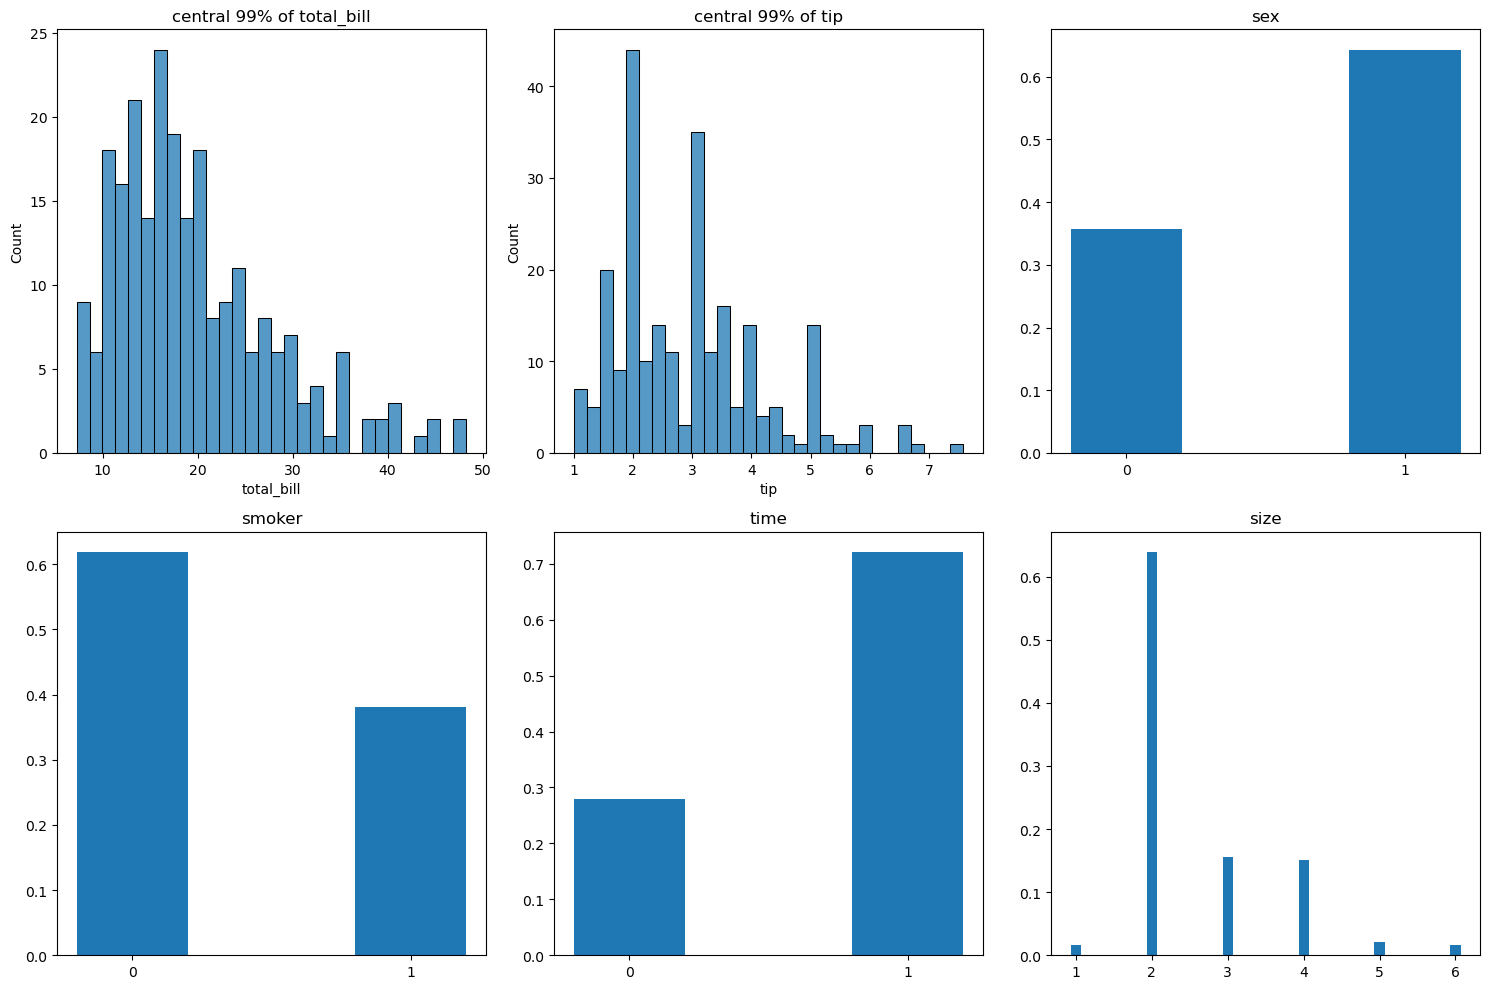

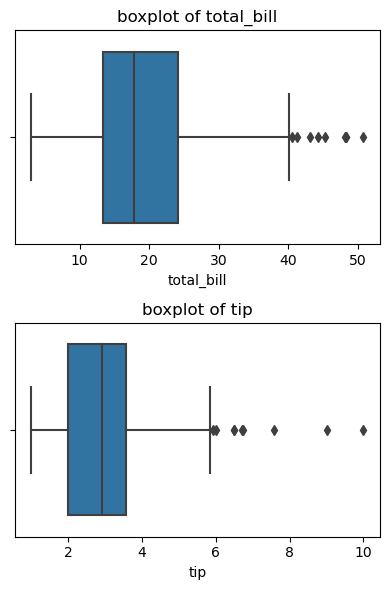

In [6]:
# create a histogram for each numeric column
rutils.create_column_histograms(df, hist_tail_cut=1)

# boxplots
rutils.create_column_boxplot(df, separate_panels=True)

## Log-transform *bill* and *tip*

In [7]:
df['total_bill_log'] = np.log(df['total_bill'])
df['tip_log'] = np.log(df['tip'])

# Visualizing the transformed columns

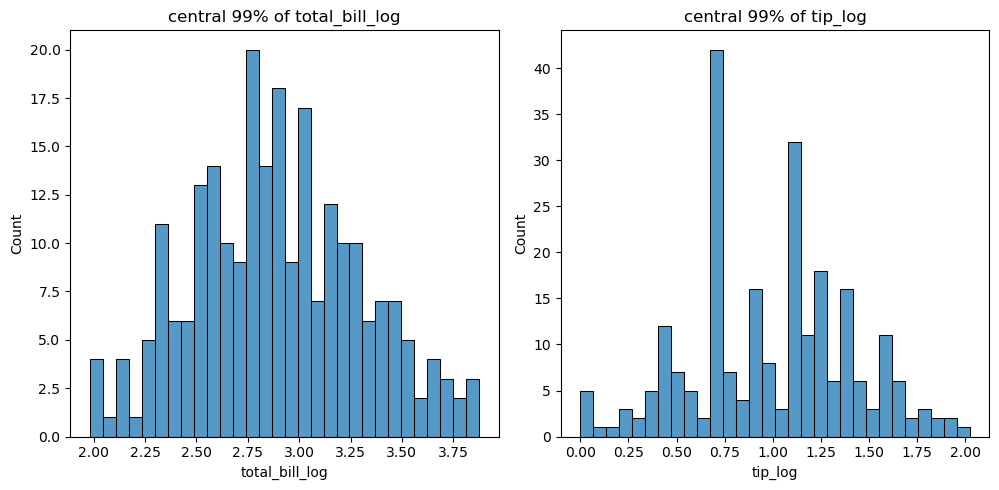

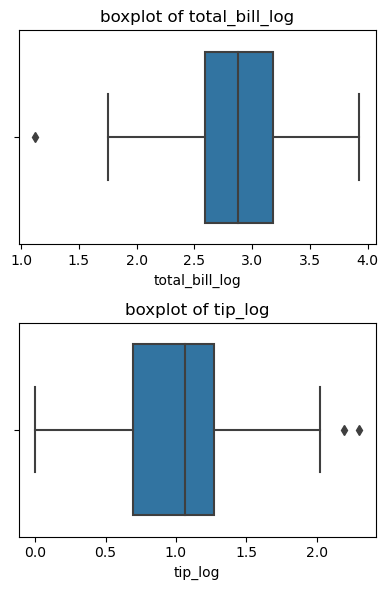

In [8]:
# create a histogram for each numeric column
rutils.create_column_histograms(df[['total_bill_log', 'tip_log']], hist_tail_cut=1)

# boxplots
rutils.create_column_boxplot(df[['total_bill_log', 'tip_log']], separate_panels=True)

## Identifying/correcting errors (if needed)
There are no signs of errors, so nothing needs to be corrected

## Filling/removing missing values (if needed)
There are no missing values, so nothing needs to be done here

## Removing outliers (if needed)
There are some outliers, but nothing serious -- we will keep them for the moment

## Transformation (Standardization/Normalization)
We have only two continuous variables in our data and both seem well-behaved (close-to-normal distributions with values in the same order of magnitude as all other variables). There seems no need to standardize or normalize these data, so for now we leave it as it is.

## Analyze relationships between features (correlation matrix)

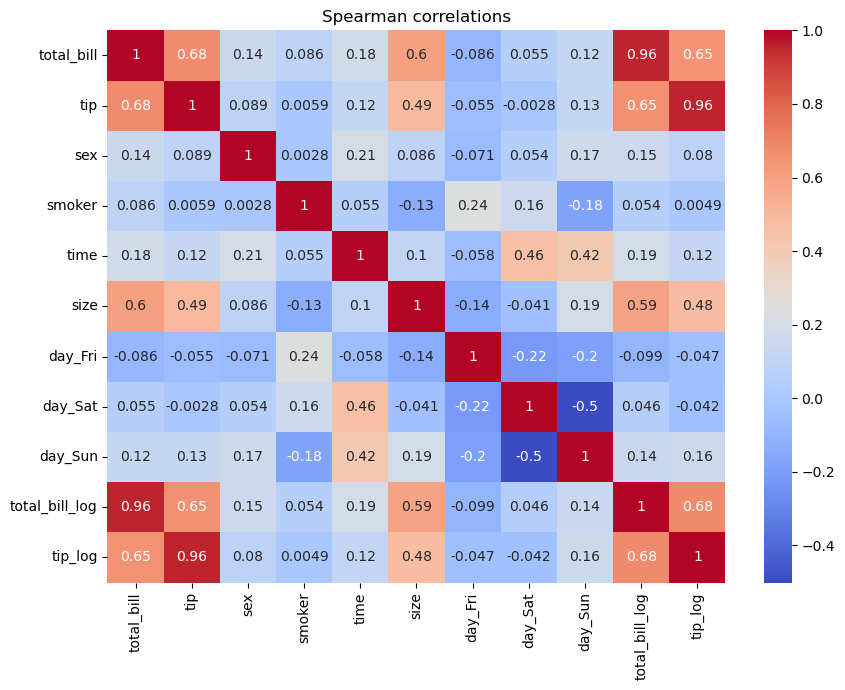

In [9]:
rutils.create_corr_plot(df, target_col='tip', threshold=0)

## Visualize the relation between the target (tip amount) and each feature

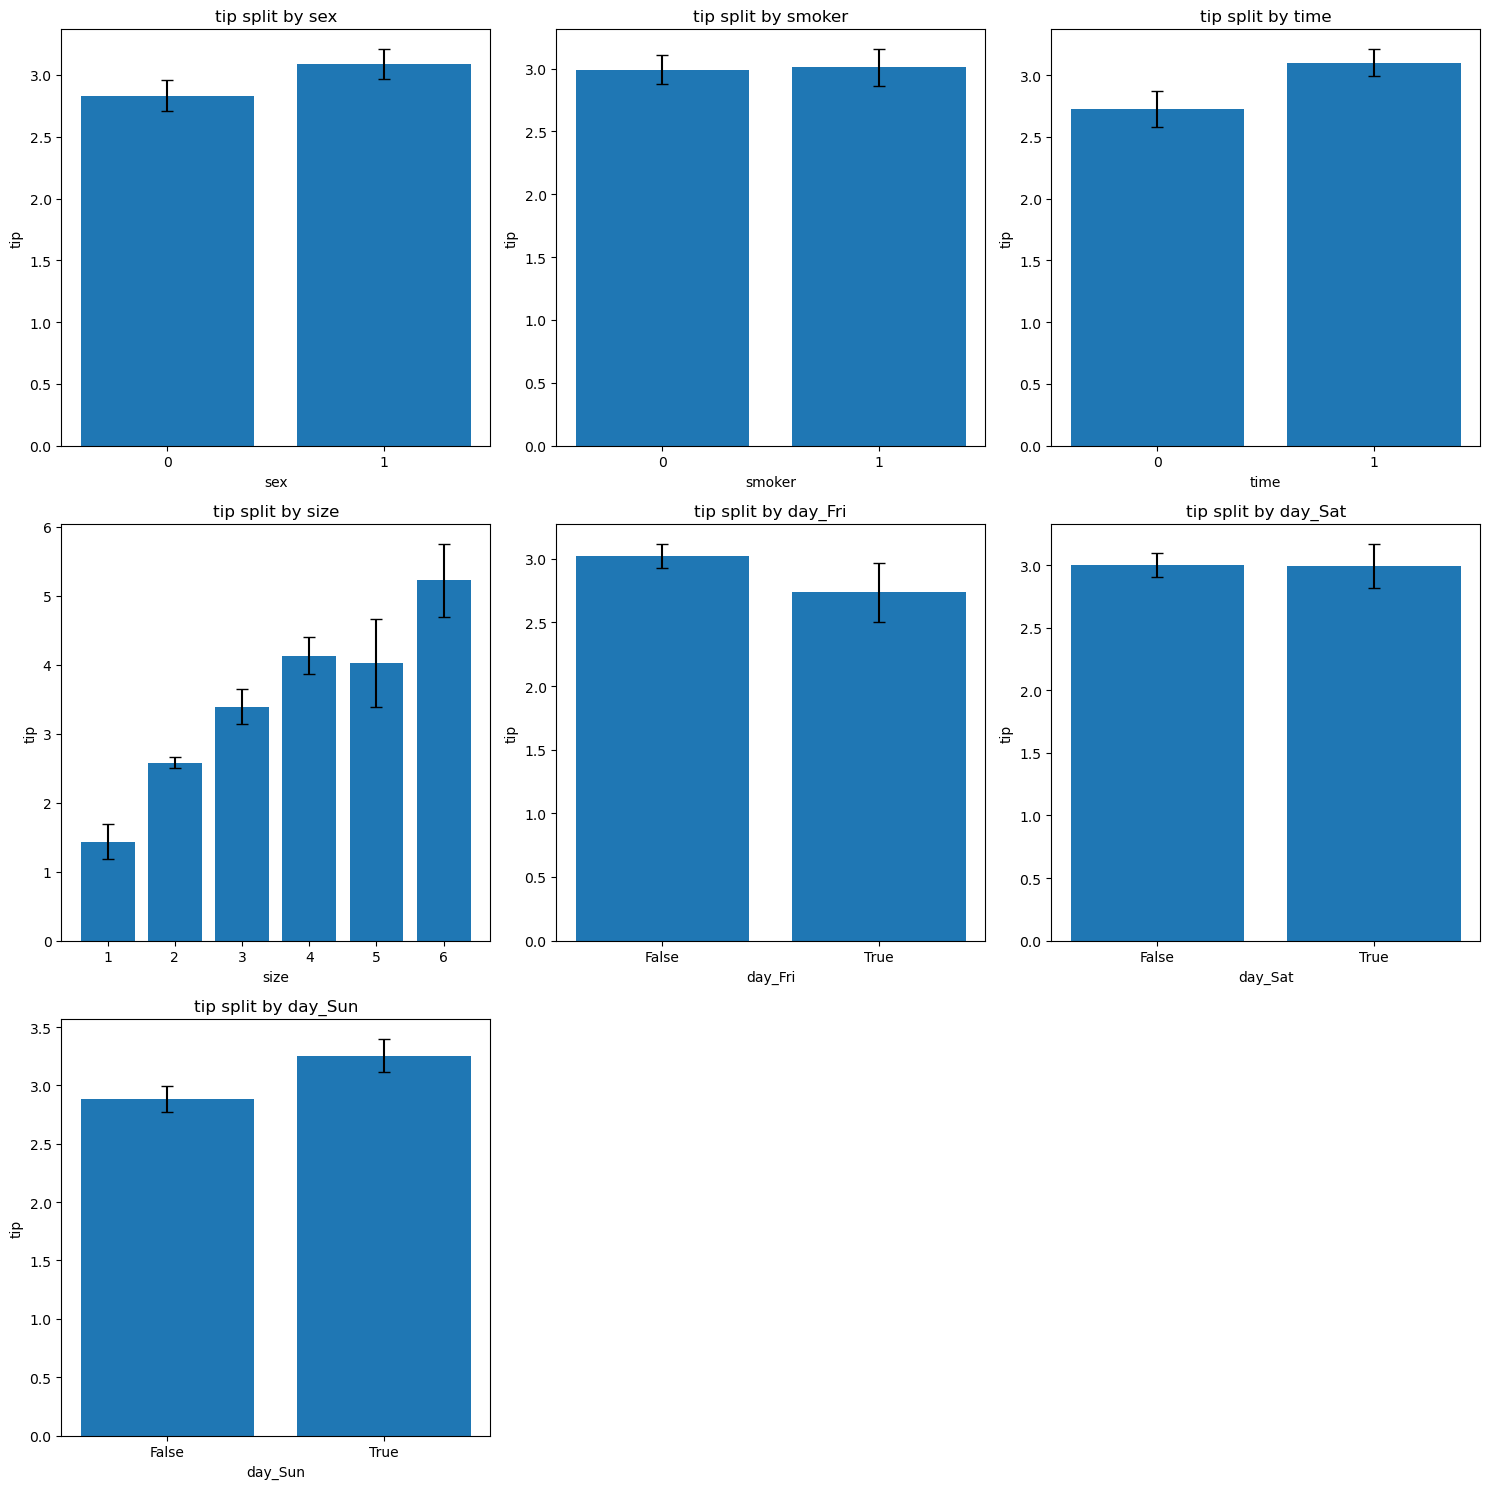

In [10]:
rutils.plot_target_split_by_categorical(df, 'tip')

## Plot the correlation between total_bill and tip

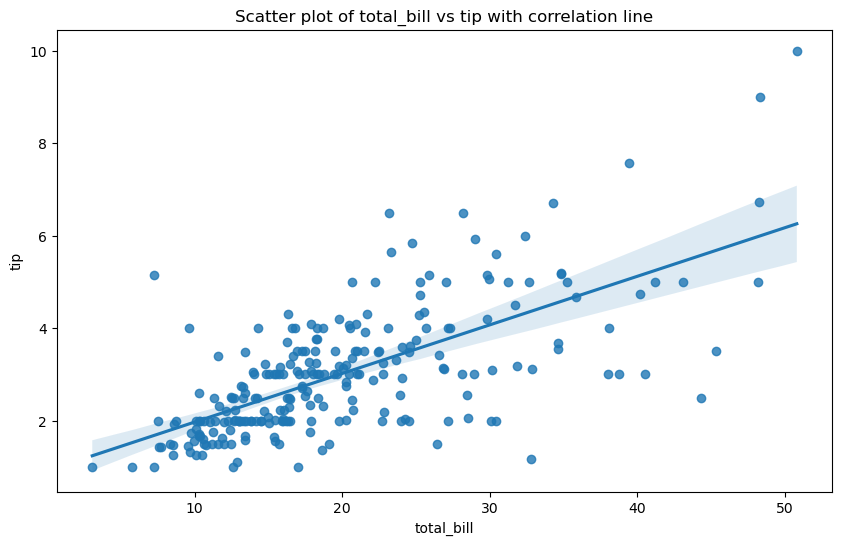

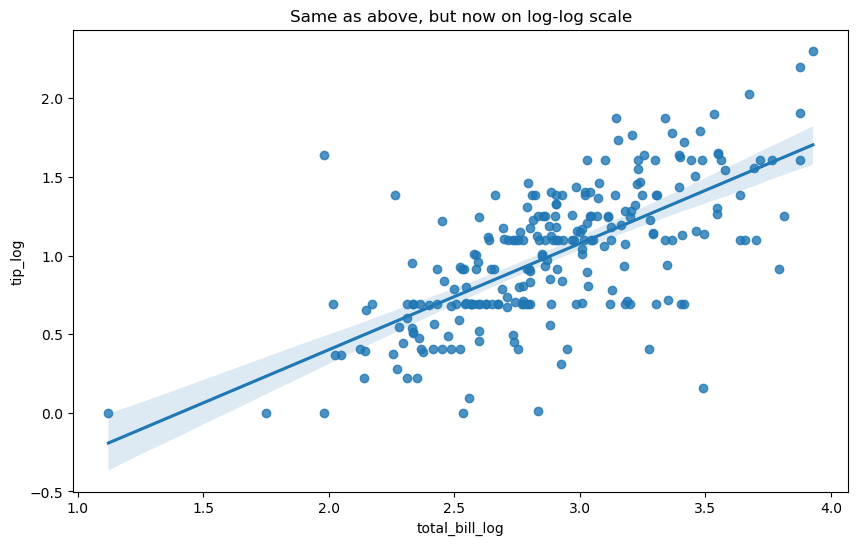

In [11]:
plt.figure(figsize=(10,6))
sns.regplot(x='total_bill', y='tip', data=df)
plt.title('Scatter plot of total_bill vs tip with correlation line')
plt.show()

plt.figure(figsize=(10,6))
sns.regplot(x='total_bill_log', y='tip_log', data=df)
plt.title('Same as above, but now on log-log scale')
plt.show()

## Rank the features using Random forest

In [12]:
target_var = 'tip'
feature_vars = ['total_bill', 'total_bill_log', 'sex', 'smoker', 'time', 'day_Fri', 'day_Sat', 'day_Sun']
                
# rank the features using a Random Forest 
rf = RandomForestRegressor()
rf.fit(df[feature_vars], df[target_var])
imps_RF = rf.feature_importances_
imps_df = pd.DataFrame({
    'Feature': feature_vars,  
    'Importance_RF': imps_RF
})

# Sort dataframe
imps_df.sort_values(by='Importance_RF', ascending=False, inplace=True)
imps_df

,Feature,Importance_RF
0,total_bill,0.43
1,total_bill_log,0.40
3,smoker,0.07
6,day_Sat,0.03
7,day_Sun,0.02
2,sex,0.02
4,time,0.02
5,day_Fri,0.01


## Use certain features not all the features (up to you to choose the features)
* We have a very small dataset, so there's no real advantage to drop features (more information = better, as long as it's computationally feasible)
* However, we duplicated two columns by adding log-transformed versions of them. We will drop the original (non-log-transformed) *total_bill* and *tip* columns, because the log-transformed ones seem slightly better behaved

In [13]:
df = df.drop('total_bill', axis=1)
df = df.drop('tip', axis=1)
df

,sex,smoker,time,size,day_Fri,day_Sat,day_Sun,total_bill_log,tip_log
0,0,0,1,2,False,False,True,2.83,0.01
1,1,0,1,3,False,False,True,2.34,0.51
2,1,0,1,3,False,False,True,3.04,1.25
3,1,0,1,2,False,False,True,3.16,1.20
4,0,0,1,4,False,False,True,3.20,1.28
...,...,...,...,...,...,...,...,...,...
239,1,0,1,3,False,True,False,3.37,1.78
240,0,1,1,2,False,True,False,3.30,0.69
241,1,1,1,2,False,True,False,3.12,0.69
242,1,0,1,2,False,True,False,2.88,0.56


## Split the data into train and test (80-20)

In [14]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=20230629)
X_train = df_train.drop('tip_log', axis=1)
y_train = df_train['tip_log']
X_test = df_test.drop('tip_log', axis=1)
y_test = df_test['tip_log']

## Use different base models, use RandomizedSearchCV, use a pipeline
I will try the following three commonly used regression models:
1. Linear regression
2. Random forest regression
3. Gradient boosting regression

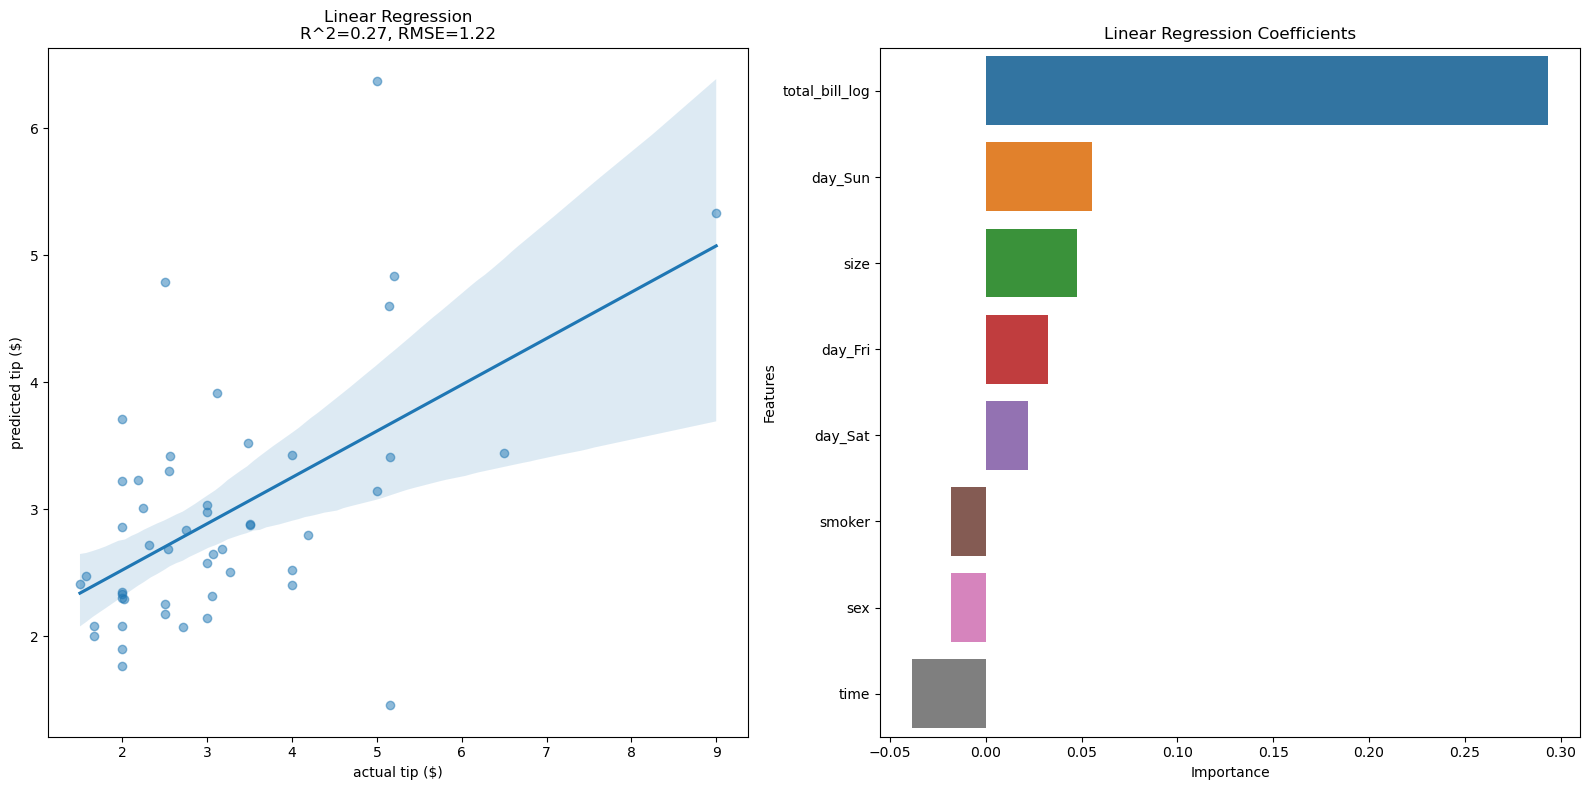

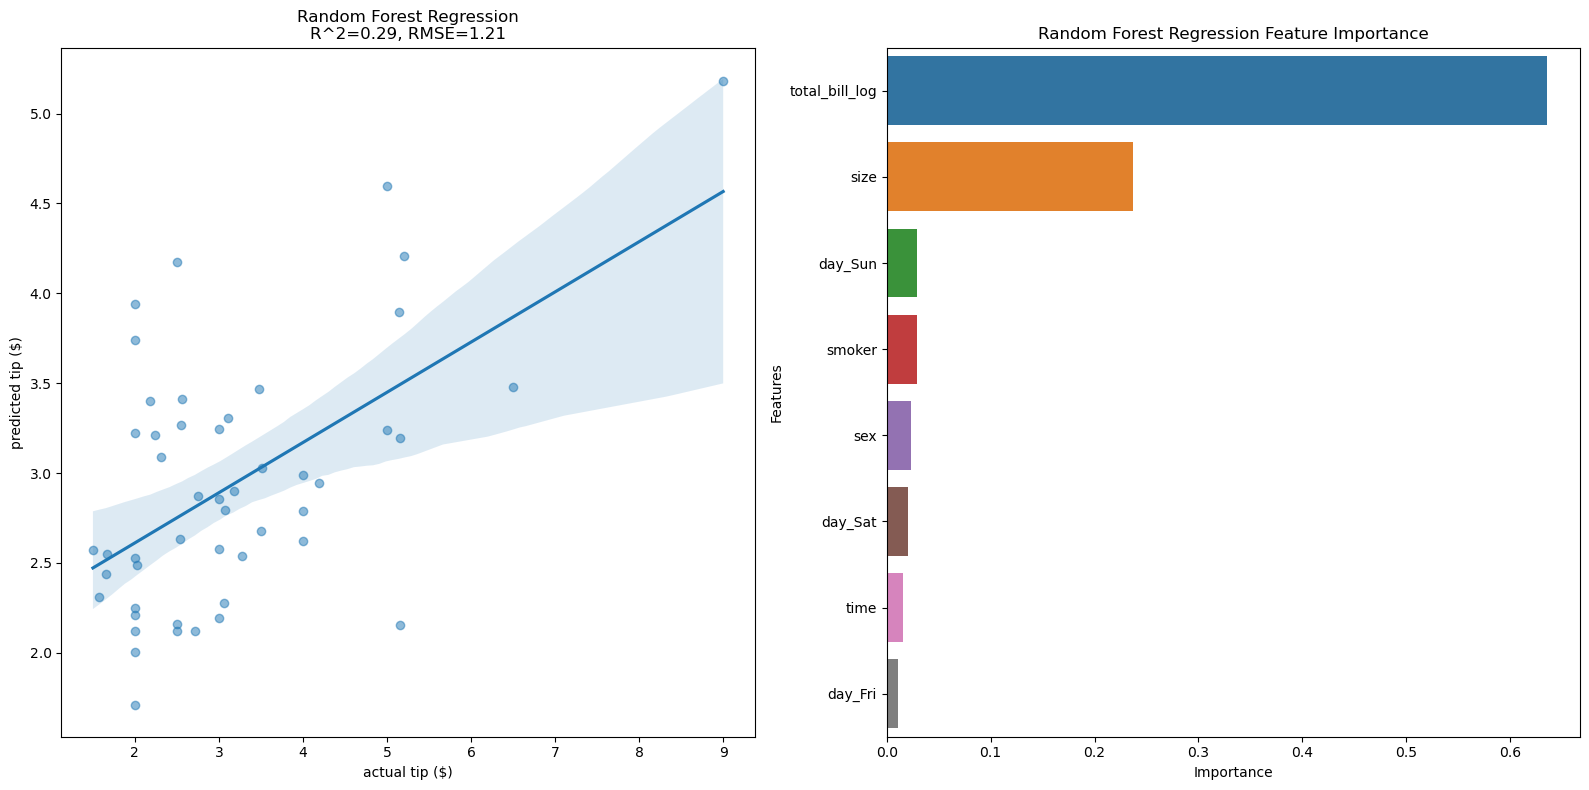

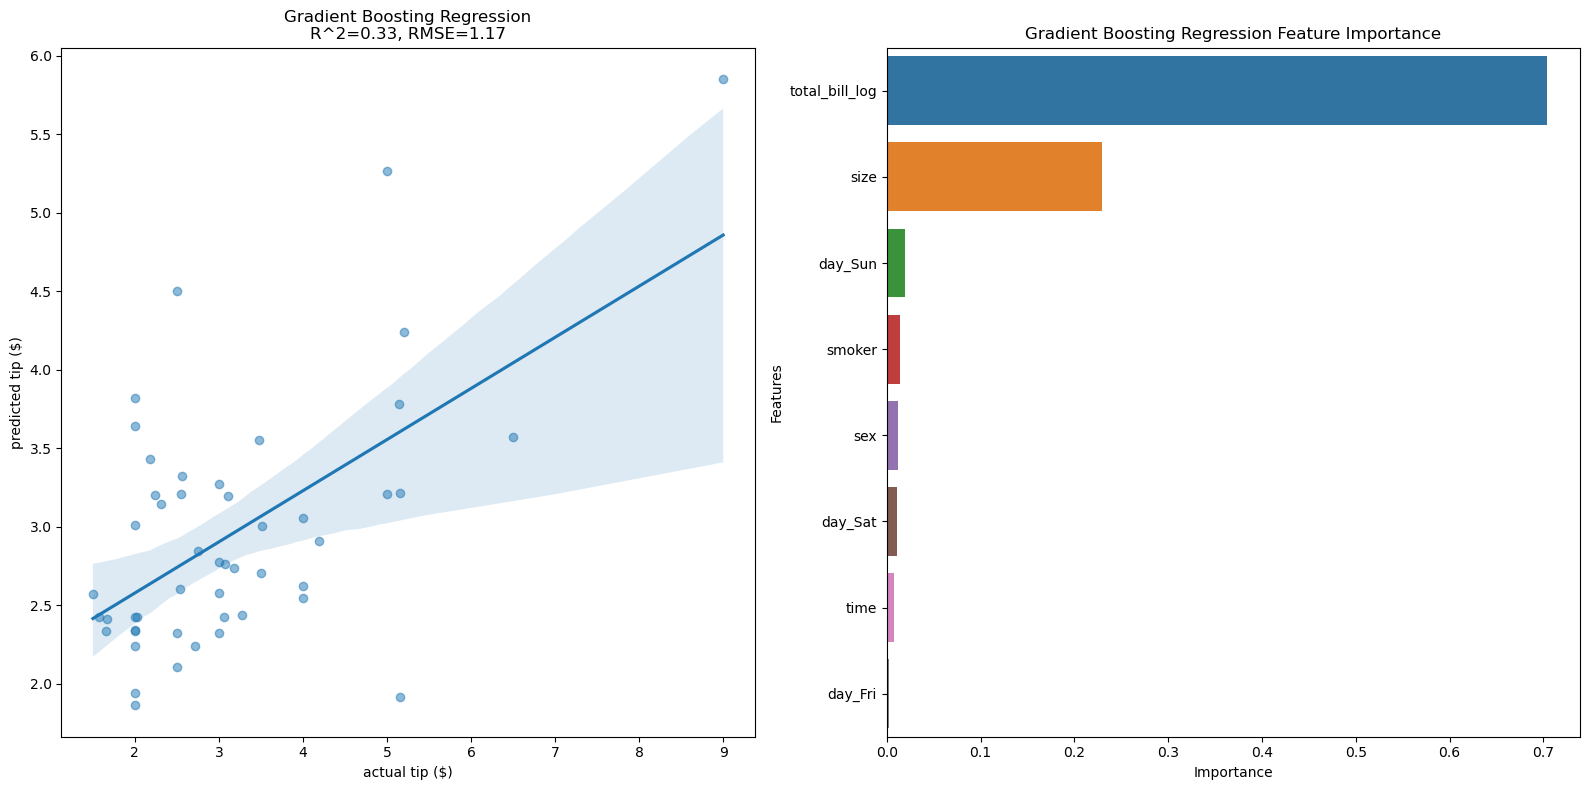

In [15]:
# models
models = {
    'Linear Regression': make_pipeline(StandardScaler(), LinearRegression()),
    'Random Forest Regression': make_pipeline(StandardScaler(), RandomForestRegressor(random_state=20230629)),
    'Gradient Boosting Regression': make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=20230629))
}

# hyperparamater spaces
param_distributions = {
    'Linear Regression': { 
        'linearregression__fit_intercept': [True, False]
    },
    'Random Forest Regression': {
        'randomforestregressor__n_estimators': [100, 200, 300],
        'randomforestregressor__max_depth': [None, 10, 20, 30],
        'randomforestregressor__min_samples_split': [2, 5, 10],
        'randomforestregressor__min_samples_leaf': [1, 2, 4],
        'randomforestregressor__max_features': ['auto', 'sqrt']
    },
    'Gradient Boosting Regression': {
        'gradientboostingregressor__n_estimators': [100, 200, 300],
        'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
        'gradientboostingregressor__max_depth': [3, 5, 8],
        'gradientboostingregressor__min_samples_split': [2, 5, 10],
        'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
        'gradientboostingregressor__max_features': ['auto', 'sqrt']
    }
}

# loop over models
best_hyperpars = []  # store best hyperparameters for later use in the ensemble modeling
for name, model in models.items():
    
    # fit the model (find best hyperparameter values)
    n_combinations = len(list(itertools.product(*param_distributions[name].values())))
    random_search = RandomizedSearchCV(estimator=model, 
                                       param_distributions=param_distributions[name], 
                                       n_iter=min(100, n_combinations), 
                                       n_jobs=-1, 
                                       scoring='neg_root_mean_squared_error', 
                                       random_state=20230629,
                                       cv=5 # redundant, because it's the default
                                      )
    random_search.fit(X_train, y_train)
    best_hyperpars.append((name, random_search.best_estimator_))

    # compute predictions and error measures (rmse and r^2)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
    r2 = r2_score(np.exp(y_test), np.exp(y_pred))

    # create a figure with 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # plot the actual vs predicted values
    sns.regplot(x=np.exp(y_test), y=np.exp(y_pred), scatter_kws={'alpha':0.5}, ax=ax[0])
    ax[0].set_xlabel('actual tip ($)')
    ax[0].set_ylabel('predicted tip ($)')
    ax[0].set_title(f'{name}\nR^2={r2:.2f}, RMSE={rmse:.2f}')

    # get the model from the pipeline
    model_name = list(best_model.named_steps.keys())[-1]
    
    # display feature importance or coefficients for models
    if name == 'Linear Regression':
        feature_importances = best_model.named_steps[model_name].coef_
        features = X_train.columns
        importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
        importance_df.sort_values(by='Importance', ascending=False, inplace=True)
        sns.barplot(x='Importance', y='Features', data=importance_df, ax=ax[1])
        ax[1].set_title(f'{name} Coefficients')
    elif name in ['Random Forest Regression', 'Gradient Boosting Regression']:
        feature_importances = best_model.named_steps[model_name].feature_importances_
        features = X_train.columns
        importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
        importance_df.sort_values(by='Importance', ascending=False, inplace=True)
        sns.barplot(x='Importance', y='Features', data=importance_df, ax=ax[1])
        ax[1].set_title(f'{name} Feature Importance')

    plt.tight_layout()
    plt.show()

## Use ensembling techniques to see if there is any improvement in the overall accuracy.

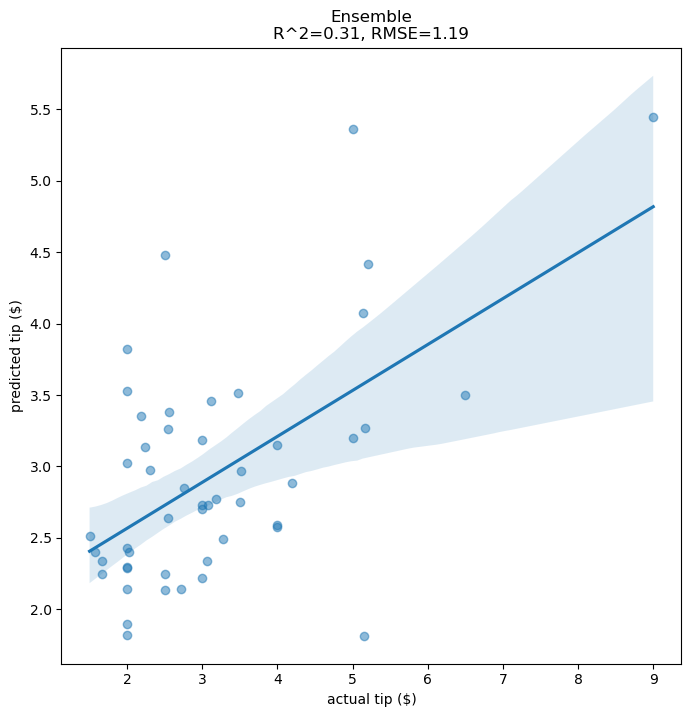

In [16]:
# create an ensemble of the best models
ensemble = VotingRegressor(estimators=best_hyperpars)

# fit the ensemble model
ensemble.fit(X_train, y_train)

# compute predictions and error measures (rmse and r^2)
y_pred = ensemble.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
r2 = r2_score(np.exp(y_test), np.exp(y_pred))

# create a figure
fig, ax = plt.subplots(figsize=(8, 8))

# plot the actual vs predicted values
sns.regplot(x=np.exp(y_test), y=np.exp(y_pred), scatter_kws={'alpha':0.5}, ax=ax)
ax.set_xlabel('actual tip ($)')
ax.set_ylabel('predicted tip ($)')
ax.set_title(f'Ensemble\nR^2={r2:.2f}, RMSE={rmse:.2f}')

plt.show()

## Plot the test set using only two principal components

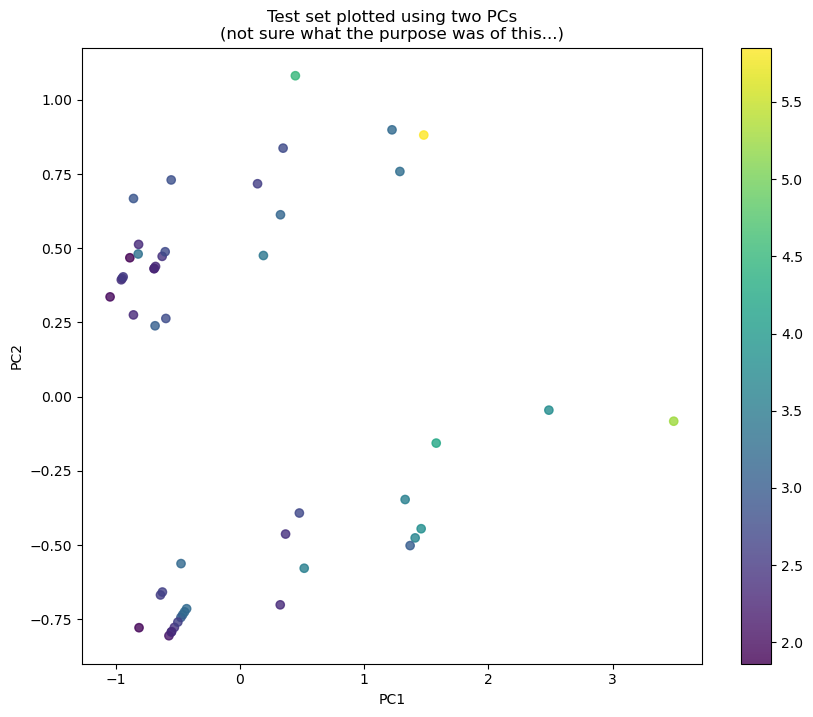

In [17]:
# reduce data to two PCs
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# prepare a dataframe for the plot
df_test_pca = pd.DataFrame(data = X_test_pca, columns = ['PC1', 'PC2'])
df_test_pca['predicted_tip'] = best_model.predict(X_test)

# Create the scatter plot (heatmap)
plt.figure(figsize=(10,8))
sc = plt.scatter(df_test_pca['PC1'], df_test_pca['PC2'], 
                 alpha=0.8, 
                 c=np.exp(df_test_pca['predicted_tip']), 
                 cmap='viridis')
plt.colorbar(sc)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Test set plotted using two PCs\n(not sure what the purpose was of this...)')
plt.show()

## Test set plotted against the two most informative features

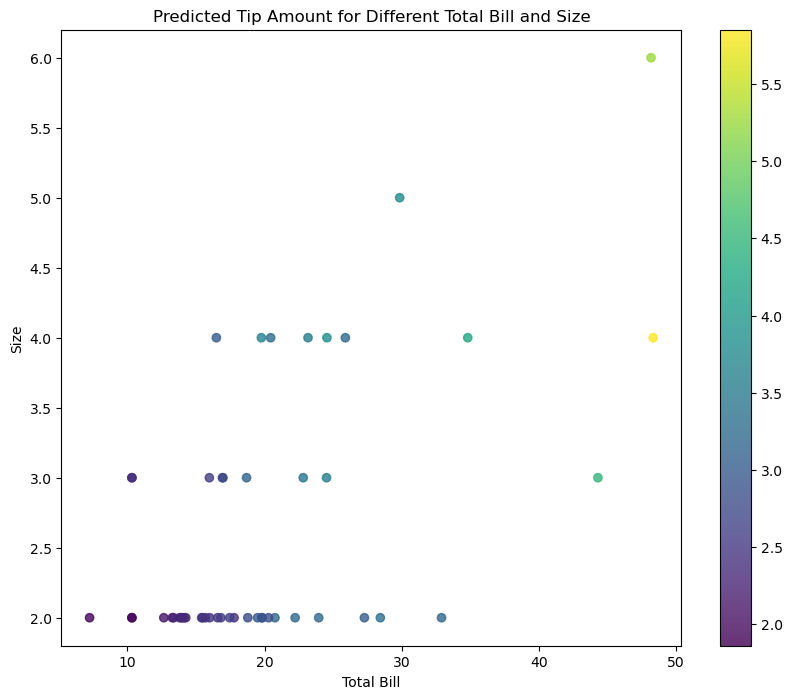

In [18]:
# Prepare a dataframe for the plot
df_test = pd.DataFrame(data = X_test, columns = X_test.columns)
df_test['predicted_tip'] = best_model.predict(X_test)

# Create the scatter plot
plt.figure(figsize=(10,8))
sc = plt.scatter(np.exp(df_test['total_bill_log']), df_test['size'], 
                 alpha=0.8, 
                 c=np.exp(df_test['predicted_tip']), 
                 cmap='viridis')
plt.colorbar(sc)
plt.xlabel('Total Bill')
plt.ylabel('Size')
plt.title('Predicted Tip Amount for Different Total Bill and Size')
plt.show()

## Appendix: predicting the tip using a single feature

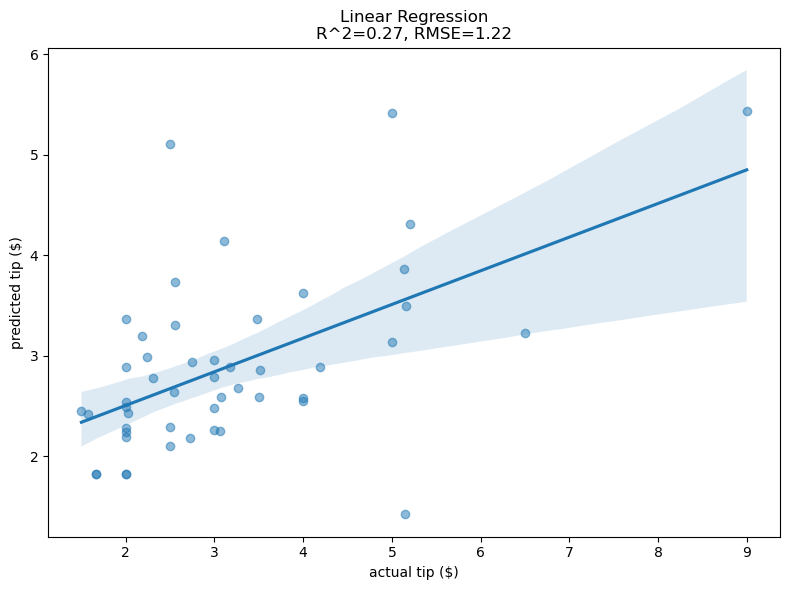

In [19]:
selected_features = ['total_bill_log']

# select a subset of features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# fit linear regression model
name = 'Linear Regression'
model = models[name]
n_combinations = len(list(itertools.product(*param_distributions[name].values())))
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_distributions[name], 
                                   n_iter=min(100, n_combinations), 
                                   n_jobs=-1, 
                                   scoring='neg_root_mean_squared_error', 
                                   random_state=20230629)
random_search.fit(X_train_selected, y_train)

# compute predictions and error measures (rmse and r^2)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_selected)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
r2 = r2_score(np.exp(y_test), np.exp(y_pred))

# plot the actual vs predicted values
plt.figure(figsize=(8, 6))
sns.regplot(x=np.exp(y_test), y=np.exp(y_pred), scatter_kws={'alpha':0.5})
plt.xlabel('actual tip ($)')
plt.ylabel('predicted tip ($)')
plt.title(f'{name}\nR^2={r2:.2f}, RMSE={rmse:.2f}')
plt.tight_layout()
plt.show()


## Conclusion
The total bill amount is by far the strongest predictor of the tip. 

Adding other information, like group size and day of the week, doesn't substantially improve predictive power.

**tips**

* Try SMOT (oversampling)
* Try data augmentation